## **Compute**

A Jupyter notebook talking about computing a synthetic model in PHOEBE. This roughly follows the given tutorial provided at https://phoebe-project.org/docs/2.4/.

### Setup

Let's quickly install PHOEBE (if needed), load it and other librarys, set up the logger and load the default binary Bundle.

In [1]:
# !pip install phoebe

In [1]:
import phoebe as phb
import numpy as np
import matplotlib.pyplot as plt

In [2]:
logger = phb.logger()
bSystem = phb.default_binary()

Let's also attach some dummy datasets to get things running.

In [4]:
bSystem.add_dataset(
    'orb',
    compute_times = phb.linspace(0, 10, 10),
    dataset = 'orb01'
)

bSystem.add_dataset(
    'lc',
    compute_times = phb.linspace(0, 1, 101),
    dataset = 'lc01'
)

<ParameterSet: 80 parameters | contexts: figure, dataset, constraint, compute>

### Default Compute Options

Any default Bundle has a set of default compute options to run the backend for PHOEBE. In most cases, you can just edit the options in the default set.

In [5]:
print(bSystem.computes)

['phoebe01']


In [6]:
print(bSystem['compute'])

ParameterSet: 20 parameters
     sample_from@phoebe01@compute: []
        comments@phoebe01@compute: 
      use_server@phoebe01@compute: none
   dynamics_method@phoebe01@co...: keplerian
            ltte@phoebe01@compute: False
    irrad_method@phoebe01@compute: horvat
   boosting_method@phoebe01@co...: none
   eclipse_method@phoebe01@com...: native
   horizon_method@phoebe01@com...: boolean
   mesh_method@primary@phoebe0...: marching
   mesh_method@secondary@phoeb...: marching
   ntriangles@primary@phoebe01...: 1500
   ntriangles@secondary@phoebe...: 1500
   distortion_method@primary@p...: roche
   distortion_method@secondary...: roche
     atm@primary@phoebe01@compute: ck2004
   atm@secondary@phoebe01@compute: ck2004
   enabled@orb01@phoebe01@compute: True
    enabled@lc01@phoebe01@compute: True
      fti_method@phoebe01@compute: none


The above lists all the options for the default compute, and can be changed by setting the parameter to a specified number/option. Reminder: You can use `bSystem.get_limits` and `bSystem.get_choices` to see what is valid.

### Adding Compute Options

In other cases, you can manually add additional sets of compute options. This can be done using `bSystem.add_compute`.

In this example, we want to add two sets of compute options to work with. These will be labelled as 'preview', which runs a quick model at the expense of accuracy, and 'detailed', which gives an accurate model at the expense of compute time.

In [7]:
bSystem.add_compute(
    'phoebe', # Compute model to use, which this just loads the default one
    compute = 'preview', # Label for our compute option, which is 'preview'
    irrad_method = 'none' # Changes the irrad method (which can be seen in the list of options in the previous code block) to none
)

bSystem.add_compute(
    'phoebe', # Compute model to use, which this just loads the default one
    compute = 'detailed', # Label for our compute option, which is 'detailed'
    irrad_method = 'wilson' # Changes the irrad method (which can be seen in the list of options in the previous code block) to wilson
)

<ParameterSet: 40 parameters | datasets: _default, orb01, lc01>

In [8]:
print(bSystem['compute@preview'])
print('\nIrradiation Method: {}'.format(bSystem['compute@preview@irrad_method'].get_value()))

ParameterSet: 20 parameters
      sample_from@preview@compute: []
         comments@preview@compute: 
       use_server@preview@compute: none
   dynamics_method@preview@com...: keplerian
             ltte@preview@compute: False
     irrad_method@preview@compute: none
   boosting_method@preview@com...: none
   eclipse_method@preview@compute: native
   horizon_method@preview@compute: boolean
    enabled@orb01@preview@compute: True
     enabled@lc01@preview@compute: True
   mesh_method@primary@preview...: marching
   mesh_method@secondary@previ...: marching
   ntriangles@primary@preview@...: 1500
   ntriangles@secondary@previe...: 1500
   distortion_method@primary@p...: roche
   distortion_method@secondary...: roche
      atm@primary@preview@compute: ck2004
    atm@secondary@preview@compute: ck2004
       fti_method@preview@compute: none

Irradiation Method: none


In [9]:
print(bSystem['compute@detailed'])
print('\nIrradiation Method: {}'.format(bSystem['compute@detailed@irrad_method'].get_value()))

ParameterSet: 20 parameters
     sample_from@detailed@compute: []
        comments@detailed@compute: 
      use_server@detailed@compute: none
   dynamics_method@detailed@co...: keplerian
            ltte@detailed@compute: False
    irrad_method@detailed@compute: wilson
   boosting_method@detailed@co...: none
   eclipse_method@detailed@com...: native
   horizon_method@detailed@com...: boolean
   enabled@orb01@detailed@compute: True
    enabled@lc01@detailed@compute: True
   mesh_method@primary@detaile...: marching
   mesh_method@secondary@detai...: marching
   ntriangles@primary@detailed...: 1500
   ntriangles@secondary@detail...: 1500
   distortion_method@primary@d...: roche
   distortion_method@secondary...: roche
     atm@primary@detailed@compute: ck2004
   atm@secondary@detailed@compute: ck2004
      fti_method@detailed@compute: none

Irradiation Method: wilson


### Editing Compute Options

Most of the parameters in the compute options are specific to the backend being used. We've only used the PHOEBE 2.4 backend, but others exist.

Different datasets will have their own specific compute options. The ones for light curves is at https://phoebe-project.org/docs/2.4/tutorials/LC.

### Enabling/Disabling Datasets

By default, synthetic models will be created for all datasets in the Bundle when `bSystem.run_compute` is called. Datasets can be disabled so that `run_compute` ignores it, which is controlled by the parameter 'enabled' in the dataset.

The 'enabled' parameter is separate for each compute option. Hence, you can set the dataset to be enabled/disabled for specific datasets. You can use the `bSystem.set_value_all` to enable/disable the dataset for all compute options.

In [10]:
print(bSystem['enabled@lc01'])

ParameterSet: 3 parameters
    enabled@lc01@phoebe01@compute: True
     enabled@lc01@preview@compute: True
    enabled@lc01@detailed@compute: True


In [11]:
bSystem['preview@enabled@lc01'] = False
bSystem['phoebe01@enabled@lc01'] = False
print(bSystem['enabled@lc01'])

ParameterSet: 3 parameters
    enabled@lc01@phoebe01@compute: False
     enabled@lc01@preview@compute: False
    enabled@lc01@detailed@compute: True


In [12]:
bSystem.set_value_all('enabled@lc01', True)
print(bSystem['enabled@lc01'])

ParameterSet: 3 parameters
    enabled@lc01@phoebe01@compute: True
     enabled@lc01@preview@compute: True
    enabled@lc01@detailed@compute: True


PHOEBE can automatically disable datasets for specific compute options, if a compute option does not support that dataset type.

## Running Compute

`bSystem.run_compute` takes arguments for the compute tag as well as the model tag for the resulting synthetic model(s).

The compute tag doesn't need to be provideed if only 0 or 1 set of compute options exists in the Bundle. If 0 exist, then the default PHOEBE 2.4 options will be added and used. If 1 exists, it will assume that you are using those.
If there are more than 1, then the tag must be provided.

If a tag isn't provided for the model, one will be created under the name 'latest'. This can be overwritten without any errors, whilst naming it anything else will throw an error if the `overwrite=True` tag is NOT provided. 
It is best practice to provide a model tag.

In [19]:
bSystem.run_compute(compute='preview')
print(bSystem.models)

100%|██████████| 110/110 [00:00<00:00, 149.38it/s]

['latest']


Now let's run 3 different models with inclinations 90 deg, 85 deg and 80 deg. This will use the preview compute option and we will provide different model tags to store the results

In [20]:
bSystem['incl@orbit'] = 90
bSystem.run_compute(compute='preview', model='incl_90')

bSystem['incl@orbit'] = 85
bSystem.run_compute(compute='preview', model='incl_85') 

bSystem['incl@orbit'] = 80
bSystem.run_compute(compute='preview', model='incl_80') 

100%|██████████| 110/110 [00:04<00:00, 22.87it/s]


<ParameterSet: 17 parameters | kinds: orb, lc>

In [21]:
print(bSystem.models)

['latest', 'incl_90', 'incl_85', 'incl_80']


Models can be removed using `bSystem.remove_model` and specifying the model.

Synthetic data can be accessed via their dataset and model tags.

In [25]:
incl_90 = bSystem['incl_90@primary']
print(incl_90['us'])

print(incl_90['us'].get_value())

Parameter: us@primary@incl_90@model
                       Qualifier: us
                     Description: U position
                           Value: [ 1.62265701e-16 -1.70338717e+00 -2.60974055e+00 ...
  2.60974055e+00  1.70338717e+00  2.13453210e-14] solRad
                  Constrained by: 
                      Constrains: None
                      Related to: None

[ 1.62265701e-16 -1.70338717e+00 -2.60974055e+00 -2.29496732e+00
 -9.06353380e-01  9.06353380e-01  2.29496732e+00  2.60974055e+00
  1.70338717e+00  2.13453210e-14]


## compute_times & compute_phases

### Overriding Computation Times

If `compute_times` is not empty, the provided value will be used to compute the model instead of those in the `times` parameter.

`compute_times` will override the values in `times` when computing the model. However, passing `times` as a keyword into `bSystem.run_compute` will override precidence over both. Hence the hierarchy is:
1. `bSystem.run_compute(times=[0, 0.5, 1])`
2. `bSystem.add_dataset('lc', compute_times=[0, 0.5, 1])`
3. `bSystem.add_dataset('lc', times=[0, 0.5, 1])`

### Phase-Time Conversion

We can alternatively provide `compute_phases` instead of `compute_times`. These parameters are linked via a constraint and needs to be inverted before using `compute_phases` (PHOEBE always uses time when computing synthetic models, so `compute_phases` is constrained by default).

In [13]:
bSystem = phb.default_binary()
bSystem.add_dataset(
    'lc',
    times=phb.linspace(0, 10, 101),
    dataset='lc01'
)

print(bSystem['compute_phases@lc01@dataset'])

Parameter: compute_phases@lc01@dataset
                       Qualifier: compute_phases
                     Description: Phases associated with compute_times.
                           Value: []
                  Constrained by: compute_times@lc01@dataset, phases_period@lc01@dataset, period@binary@component, period_anom@binary@component, phases_dpdt@lc01@dataset, dpdt@binary@component, phases_t0@lc01@dataset, t0_supconj@binary@component, t0_perpass@binary@component, t0_ref@binary@component
                      Constrains: None
                      Related to: compute_times@lc01@dataset, phases_period@lc01@dataset, period@binary@component, period_anom@binary@component, phases_dpdt@lc01@dataset, dpdt@binary@component, phases_t0@lc01@dataset, t0_supconj@binary@component, t0_perpass@binary@component, t0_ref@binary@component



In [14]:
bSystem.flip_constraint('compute_phases', solve_for='compute_times') # Flip the constraint so we can set compute_phases and have PHOEBE work out the times for us
bSystem['compute_phases'] = phb.linspace(0, 1, 11)

print(bSystem.filter(qualifier=['times', 'compute_times', 'compute_phases', 'compute_phases_t0'], context='dataset'))

ParameterSet: 3 parameters
               times@lc01@dataset: [ 0.   0.1  0.2 ...  9.8  9.9 10. ] d
C      compute_times@lc01@dataset: [0.  0.1 0.2 ... 0.8 0.9 1. ] d
      compute_phases@lc01@dataset: [0.  0.1 0.2 ... 0.8 0.9 1. ]


As we can see, the C value beside `compute_times@lc01@dataset` tells us that `compute_times` is now constrained. 

Note: `phases` does **NOT** exist for observational data. You **HAVE** to work with `times` when setting `fluxes`. If the data provided is a light curve in phase, then you need to use `bSystem.to_time` or convert the phase manually before being added to the dataset.

## Interpolation & Residuals

### Interpolation

In a given dataset, we can interpolate to a specific result or set of results within it using `bSystem.interp_value`.


In [ ]:
bSystem.run_compute()

print(bSystem['fluxes@model'].get_value())

100%|██████████| 11/11 [00:00<00:00, 86.71it/s]

[0.98306127 1.99149086 2.00580115 2.00585153 1.99153432 0.98306127
 1.99149086 2.00580115 2.00585153 1.99153432 0.98306127]


In [16]:
print(bSystem['fluxes@model'].interp_value(times=1.0))

0.9830612658250207


In [17]:
print(bSystem['fluxes@model'].interp_value(times=phb.linspace(0,3,101)))

[0.98306127 1.28559015 1.58811902 1.8906479  1.99435292 1.99864601
 2.00293909 2.00580619 2.0058213  2.00583641 2.00585153 2.00155637
 1.9972612  1.99296604 1.78983971 1.48729779 1.18475588 1.99149086
 1.99149086 1.99149086 1.99149086 1.99578395 2.00007704 2.00437012
 2.00581123 2.00582634 2.00584145 2.00441981 2.00012465 1.99582948
 1.99153432 1.68899241 1.38645049 1.08390857 1.18474719 1.48727606
 1.78980494 1.99292189 1.99721498 2.00150807 2.00580115 2.00581626
 2.00583138 2.00584649 2.00298809 1.99869293 1.99439776 1.89068702
 1.5881451  1.28560318 0.98306127 1.99149086 1.99149086 1.99149086
 1.99435292 1.99864601 2.00293909 2.00580619 2.0058213  2.00583641
 2.00585153 2.00155637 1.9972612  1.99296604 1.78983971 1.48729779
 1.18475588 1.08390423 1.38643311 1.68896198 1.99149086 1.99578395
 2.00007704 2.00437012 2.00581123 2.00582634 2.00584145 2.00441981
 2.00012465 1.99582948 1.99153432 1.68899241 1.38645049 1.08390857
 1.99149086 1.99149086 1.99149086 1.99292189 1.99721498 2.0015

When interpolating in time, it will automatically interpolate in phase-space if the provided time is outside the range of the referenced time array.

### Residuals

Residuals can be calculated using `bSystem.compute_residuals`, which handles interpolation and compares the dependent variable between model and observation. 

A test case for a light curve is given below.

In [22]:
# Setting up a dataset to generate some 'observational' data
bSystem.add_dataset( 
    'lc',
    times=phb.linspace(0, 10, 1000),
    dataset='lc01',
    overwrite=True
)

bSystem.run_compute(irrad_method='none')
bSystem['fluxes@dataset'] = bSystem['fluxes@model'].get_value() # Set observational data

bSystem.flip_constraint('compute_phases', 'compute_times') # Flip to phase-space
bSystem['teff@primary'] = 5950 # Change temp for primary
bSystem['compute_phases'] = phb.linspace(0, 1, 101)
bSystem.run_compute(irrad_method='none')

res = bSystem.calculate_residuals()
print(res)

Sun, 13 Jul 2025 14:11 BUNDLE       WARNING overwriting model: latest
100%|██████████| 1000/1000 [00:06<00:00, 145.68it/s]
Sun, 13 Jul 2025 14:11 BUNDLE       WARNING overwriting model: latest
100%|██████████| 101/101 [00:00<00:00, 135.31it/s]

[ 0.00000000e+00 -9.34652543e-06  1.09447803e-05  4.90107443e-05
  1.04192952e-04  1.86224131e-04  1.40275197e-04 -2.58917678e-08
 -3.32287420e-06  2.50028561e-06  4.21726793e-06 -8.49031037e-06
 -6.80753495e-07  1.15171833e-05 -6.62977362e-07  1.76410366e-06
 -5.56187565e-06 -3.45176548e-06 -5.25022192e-06 -1.01795458e-05
 -1.05290298e-05  5.00712508e-06  7.94615165e-06 -2.44074432e-06
 -1.30821266e-06  1.14591095e-05  1.19693019e-06 -9.63659819e-06
 -8.46684645e-06 -7.82190560e-06  1.02471593e-05 -1.99660686e-05
  9.37863614e-06 -1.24856815e-05 -6.20742672e-06 -4.93866400e-06
 -1.49325508e-05  1.17805887e-07 -2.28449783e-06 -2.41032569e-05
 -1.03032350e-05  1.09767332e-05  1.41327744e-06  1.10431727e-04
  1.89595809e-03  1.28832810e-03  8.54253208e-04  4.05553603e-04
 -1.91180617e-04 -1.65936555e-03 -1.70516106e-01 -4.48968802e-04
  2.87486102e-04  8.55848531e-04  1.39036597e-03  2.01902473e-03
  1.18807921e-03 -8.14321207e-06 -1.74743564e-05  3.50231229e-06
  2.34713981e-05  1.67777

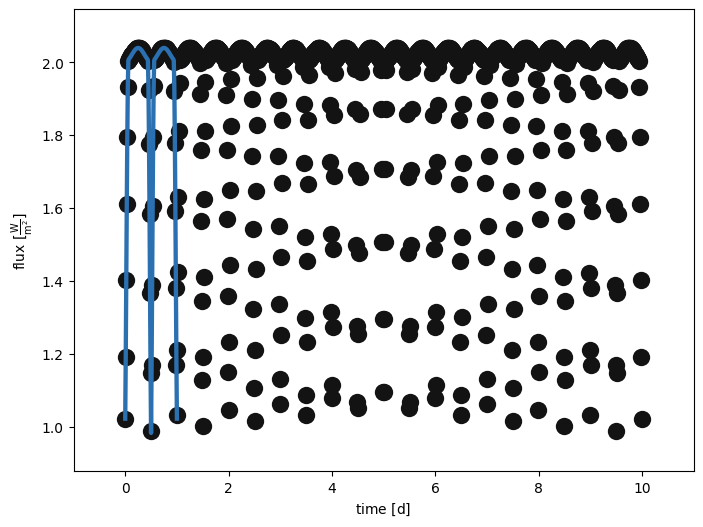

In [31]:
afig, mplfig = bSystem.plot(show=True)

Here we've only computed one cycle, whilst the 'observational' dataset extends further in time.

We can plot the residuals as well. For some reason, `bSystem.plot(y='residuals')` doesn't work so a normal matplotlib figure is created instead. `bSystem.plot(y='residuals')` would be able to calculate the residuals and plot it automatically if it worked.

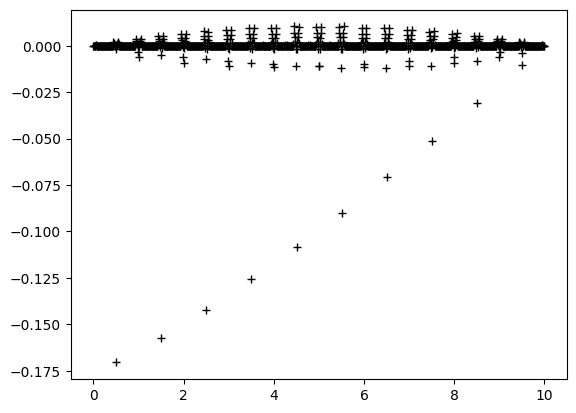

In [58]:
fig, ax = plt.subplots()
ax.plot(bSystem['times@dataset'].get_value(), res,'+', c='k')
plt.show()

## Running Multiple Computes

### Running Compute with Multiple Sets of Options

You can run multiple computes on **different** datasets with **different** options using `bSystem.run_compute` by providing a list to `compute`. Let's quickly set up everything.

In [5]:
bSystem = phb.default_binary()

bSystem.add_dataset(
    'orb',
    compute_times=phb.linspace(0,10,10),
    dataset='orb01',
    component=['primary','secondary']
)
bSystem.add_dataset(
    'lc',
    times=phb.linspace(0, 10, 100),
    dataset='lc01'
)

bSystem.add_compute(
    'phoebe',
    compute='preview',
    irrad_method='none'
)
bSystem.add_compute(
    'phoebe',
    compute='detailed',
    irrad_method='wilson'
)

<ParameterSet: 40 parameters | datasets: orb01, _default, lc01>

Let's make it so that the lightcurve dataset runs in 'detailed' mode while the orbital dataset runs in 'preview' mode.

In [6]:
# Set up orb dataset
bSystem.set_value_all('enabled@orb01', False)
bSystem['preview@enabled@orb01'] = True

# Set up lc dataset
bSystem.set_value_all('enabled@lc01', False)
bSystem['detailed@enabled@lc01'] = True

# Run compute
bSystem.run_compute(compute=['detailed', 'preview'], model='multicompute')

100%|██████████| 101/101 [00:00<00:00, 141.31it/s]


<ParameterSet: 34 parameters | kinds: orb, lc>

### Running Compute with MPI

MPI (Message Passing Interface) is a method to get code to run in parallelisation. PHOEBE has it inbuilt into `run_compute` and `run_solver`. To check if MPI is enabled, you can simply check if `phb.mpi.enabled` returns true.

In [7]:
print(phb.mpi.enabled)

False


To turn it on use `phb.mpi_on`, which you can also specify the number of processes MPI has access to. To turn it off use `phb.mpi_off`.

In [8]:
phb.mpi_on()
print(phb.mpi.enabled)

True


You can check how MPI will behave by calling `phb.mpi.mode`. You can also check the rank and number of processes with `phb.mpi.myrank` and `phb.mpi.nprocs` respectively.

In [9]:
print(phb.mpi.mode)
print(phb.mpi.myrank)
print(phb.mpi.nprocs)

internal handling of mpi in spawned separate threads during run_compute
0
4


PHOEBE will determine if the current script is running in an MPI enviroment (which you would need to do from the command line using MPI itself), which can be checked by calling `phb.mpi.within_mpirun`.

In [10]:
print(phb.mpi.within_mpirun)

False


If it is `False`, i.e. you are running Python in a serialised way, then using `phb.run_compute` will spawn a number of threads equal to the number of `nprocs` allocated.